In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 6.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

# Exercise 1

I will choose face from George W Bush, Gerhard Schroeder and Tony Blair. These are the three classes. Their target value will be 1,2,3 respectively. I will use 20 percents of the data as test dataset.

In [2]:
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split

P = 7
lfw = fetch_lfw_people(min_faces_per_person=70)
mask = np.isin(lfw.target, [3, 4, 6])
X= lfw.images[mask]
y= lfw.target[mask]
y[y==3] = 0
y[y==4] = 1
y[y==6] = 2


HEIGHT = 62
WIDTH  = 47

X_stretch = []
LOC_list = []
for num,i in enumerate(X):
    H_pad = P - HEIGHT % P
    W_pad = P - WIDTH % P
    image1_padded = np.pad(i,((0,H_pad),(0, W_pad)),mode='constant')
    H_af, W_af = image1_padded.shape
    row = None
    for h in range(int(H_af/P)):
        for w in range(int(W_af/P)):
            if row is None:
                row = image1_padded[P*h:P*(h+1), P*w:P*(w+1)].reshape(1,-1)
            else:
                row = np.concatenate((row, image1_padded[P*h:P*(h+1), P*w:P*(w+1)].reshape(1,-1)))
            if num == 0:
                LOC_list.append(np.array([P*h+P//2,P*w +P//2]))
            
    X_stretch.append(row)

X_stretch = np.stack(X_stretch)

X_train, X_test, y_train, y_test = train_test_split(
    X_stretch, y, test_size=0.2, random_state=1209)

This function keeps track of the location $z_i$ of the patches and represents it as two-dim location, (x, y). Then we can compute the loss of it. And p I choose is 13, to decrease the computation time.

In [3]:
def k_gaussian(image1, image2, sigma= 1, sigma2= 1):
    H_af, W_af = image1_padded.shape
    result = []
    
    image_len = image1.shape[0]
    for h in range(image_len):
        for w in range(h, image_len):
            loc1 = LOC_list[h]
            loc2 = LOC_list[w]
            norm1 = np.sqrt(np.sum((image1[h])**2))
            norm2 = np.sqrt(np.sum((image2[w])**2))
            dist = np.sum((image1[h]/norm1 - image2[w]/norm2)**2)
            if h == w:
                result.append(np.exp(- dist/sigma) * np.exp(-np.linalg.norm(loc1-loc2)**2/sigma2) )
            if w > h:
                result.append(2* np.exp(- dist/sigma) * np.exp(-np.linalg.norm(loc1-loc2)**2/sigma2))
    return np.sum(result)

#try to compute between the first and second in train_data

from datetime import datetime

a = datetime.now()
k_gaussian(X_train[0],X_train[1])
b = datetime.now()
print(b-a)

0:00:00.089237


In [ ]:
def nearest_mean(X_train, X_test, y_train, y_test,sigma, sigma2):
    n_train, n_test = len(X_train),len(X_test)
    result = np.zeros((n_train, n_test))
    for i in range(n_train):
        for j in range(n_test):
            result[i,j]= k_gaussian(X_train[i], X_test[j], sigma=sigma, sigma2 = sigma2)
    mask1 = (y_train == 0).astype(np.int)
    mask2 = (y_train == 1).astype(np.int)
    mask3 = (y_train == 2).astype(np.int)
    value_1 = np.dot(result.T, mask1[:, np.newaxis])/np.sum(mask1)
    value_2 = np.dot(result.T, mask2[:, np.newaxis])/np.sum(mask2)
    value_3 = np.dot(result.T, mask3[:, np.newaxis])/np.sum(mask3)
    
    value = np.concatenate((value_1,value_2,value_3),axis=1)
    prediction = np.argmax(value, axis=1)
    error_rate =np.mean(prediction == y_test)
    return error_rate


guassian_result = []
dist_result = []
parameter_list1 = [0.001,0.01, 0.1,1,10, 100]
parameter_list2 = [0.01, 1, 100]
for sigma2 in parameter_list2:
    for sigma in parameter_list1:
        error_rate = nearest_mean(X_train, X_test, y_train, y_test,sigma=sigma, sigma2=sigma2)
        guassian_result.append(error_rate)
        print('Finish one round!')

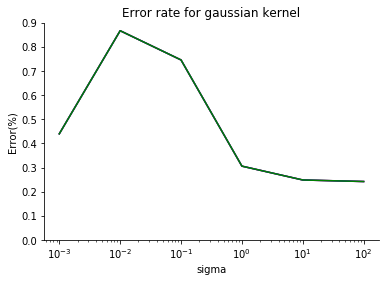

In [25]:
colors = ['red','blue','green']
fig1 = plt.subplot()
fig1.spines['right'].set_visible(False)
fig1.spines['top'].set_visible(False)

for i in range(3):
    fig1.plot(parameter_list1,guassian_result[6*i:6*(i+1)],color=colors[i], label=str(parameter_list2[i]))

fig1.set(title= 'Error rate for gaussian kernel',ylabel='Error(%)',xlabel='sigma',ylim=(0,0.9))
fig1.set_xscale('log')


The Result is as above, the three lines is overlapping. The weird thing is that although I've changed $\sigma_l$ from 0.01 to 1 to 100, The error rate only changes with the change of $\sigma_p$, which indicates the second term is dominating in this kernel function. 

# Exercise 2

## Question 1:

In [6]:
value1 = np.random.randn(50,10) + np.array(range(10))[np.newaxis,:]
value2 = np.random.randn(50,10) + np.array(range(10,20))[np.newaxis,:]
X = np.concatenate((value1,value2), axis=0)

y = np.repeat((1,2),50)

## Question 2:

I use KPCA function in this question already.

In [8]:
def power_iter(X, iteration=500):
    C = np.dot(np.dot(X.T, np.identity(len(X)) - 1/len(X) * np.ones((len(X),len(X)))), X)/(len(X)-1)

    v = np.random.randn(len(C))[:,np.newaxis]
    
    for i in range(iteration):
        temp_v = np.dot(C, v)
        v = temp_v / np.linalg.norm(temp_v)
        lam = np.dot(np.dot(v.T, C), v)
    return v, lam
      
eigen_vector, eigen_value = power_iter(X)

In [10]:
def MY_KPCA(X, kernel, n_components=2,iteration = 500, **kwargs):
    N = len(X)
    GRAM = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            GRAM[i,j] = kernel(X[i],X[j], **kwargs)
    
    norm_matrix = np.identity(N) - 1/len(X) * np.ones((len(X),len(X)))
    C = np.dot(norm_matrix, np.dot(GRAM, norm_matrix))/(len(X)-1)
    C_copy = C.copy()
    
    eigen_vectors = []
    eigen_values = []
    for i in range(n_components):
        v = np.random.randn(len(C))[:,np.newaxis]
        for i in range(iteration):
            temp_v = np.dot(C, v)
            v = temp_v / np.linalg.norm(temp_v)
            lam = np.dot(np.dot(v.T, C), v)
        eigen_vectors.append(v)
        eigen_values.append(lam)
        if i!=n_components-1:
            C -= eigen_value* v * v.T
    return C_copy, eigen_vectors, eigen_values

def poly_RBF(x1,x2,p=2):
    return (np.dot(x1,x2)+1)**p
    
    
C_copy, eigen_vectors, eigen_values = MY_KPCA(X,kernel = poly_RBF, n_components=1)

#When compute the principle component, we need to center the data.

alpha = 1/np.sqrt(eigen_values[0]) * eigen_vectors[0]

FC1 = np.dot(C_copy, alpha)

One important note is that we need to compute the principle component with the normalised gram matrix K: $\tilde{K}$.

## Question 3:

The answer is basically the same as answer of question2, I just set n_components to 2.

In [12]:
C_copy, eigen_vectors, eigen_values = MY_KPCA(X,kernel = poly_RBF, n_components=2)

#When compute the principle component, we need to center the data.

alpha1 = 1/np.sqrt(eigen_values[0]) * eigen_vectors[0]
alpha2 = 1/np.sqrt(eigen_values[1]) * eigen_vectors[1]


FC1 = np.dot(C_copy, alpha1[:])
FC2 = np.dot(C_copy, alpha2[:])

# Question 4:

[Text(0,0.5,'v2'), Text(0.5,0,'v1'), Text(0.5,1,'KPCA')]

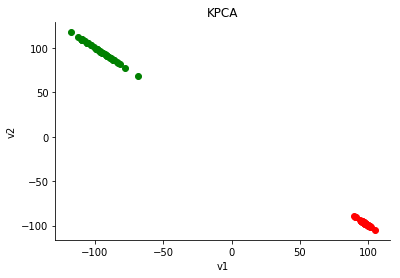

In [17]:
fig1 = plt.subplot()
fig1.spines['right'].set_visible(False)
fig1.spines['top'].set_visible(False)
colors =['r','g']
labels = ['A','B']

for i in range(2):
    fig1.plot(FC1[i*50:50*(i+1)],FC2[i*50:50*(i+1)],
             'o',color=colors[i],label= labels[i])
fig1.set(title= 'KPCA',ylabel='v2',xlabel='v1')

And I also tried p = 3 or 4, the result is as following:

[Text(0,0.5,'v2'), Text(0.5,0,'v1'), Text(0.5,1,'KPCA with p = 3')]

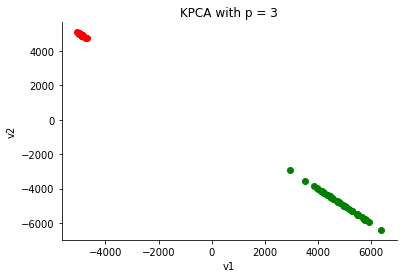

In [20]:
C_copy, eigen_vectors, eigen_values = MY_KPCA(X,kernel = poly_RBF, n_components=2, p =3)

#When compute the principle component, we need to center the data.

alpha1 = 1/np.sqrt(eigen_values[0]) * eigen_vectors[0]
alpha2 = 1/np.sqrt(eigen_values[1]) * eigen_vectors[1]


FC1 = np.dot(C_copy, alpha1[:])
FC2 = np.dot(C_copy, alpha2[:])
fig1 = plt.subplot()
fig1.spines['right'].set_visible(False)
fig1.spines['top'].set_visible(False)
colors =['r','g']
labels = ['A','B']

for i in range(2):
    fig1.plot(FC1[i*50:50*(i+1)],FC2[i*50:50*(i+1)],
             'o',color=colors[i],label= labels[i])
fig1.set(title= 'KPCA with p = 3',ylabel='v2',xlabel='v1')

[Text(0,0.5,'v2'), Text(0.5,0,'v1'), Text(0.5,1,'KPCA with p = 4')]

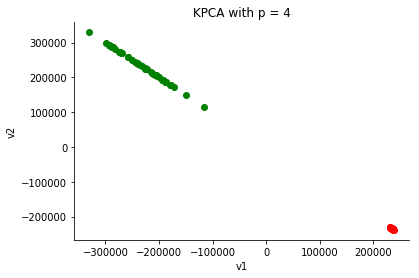

In [24]:
C_copy, eigen_vectors, eigen_values = MY_KPCA(X,kernel = poly_RBF, n_components=2, p =4)

#When compute the principle component, we need to center the data.

alpha1 = 1/np.sqrt(eigen_values[0]) * eigen_vectors[0]
alpha2 = 1/np.sqrt(eigen_values[1]) * eigen_vectors[1]


FC1 = np.dot(C_copy, alpha1[:])
FC2 = np.dot(C_copy, alpha2[:])
fig1 = plt.subplot()
fig1.spines['right'].set_visible(False)
fig1.spines['top'].set_visible(False)
colors =['r','g']
labels = ['A','B']

for i in range(2):
    fig1.plot(FC1[i*50:50*(i+1)],FC2[i*50:50*(i+1)],
             'o',color=colors[i],label= labels[i])
fig1.set(title= 'KPCA with p = 4',ylabel='v2',xlabel='v1')

When using polynomial with higher order, we can see that the seperation of data point don't change too much. But the absolute value of principal component does change a lot. With the increasing of p, the PC also increase like exponentially. 